In [ ]:
# %pip install -q pandas scikit-learn torch matplotlib optuna

## Imports

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

## Check for GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Ingestion

In [4]:
# setting random seeds for reproducibility
torch.manual_seed(42)

### Reading Dataset
Download **Fashion MNIST** Dataset [here](https://www.kaggle.com/datasets/zalando-research/fashionmnist)

In [5]:
df = pd.read_csv("/content/fashion-mnist_train.csv")
print(f"shape: {df.shape}")
df.head()

shape: (60000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


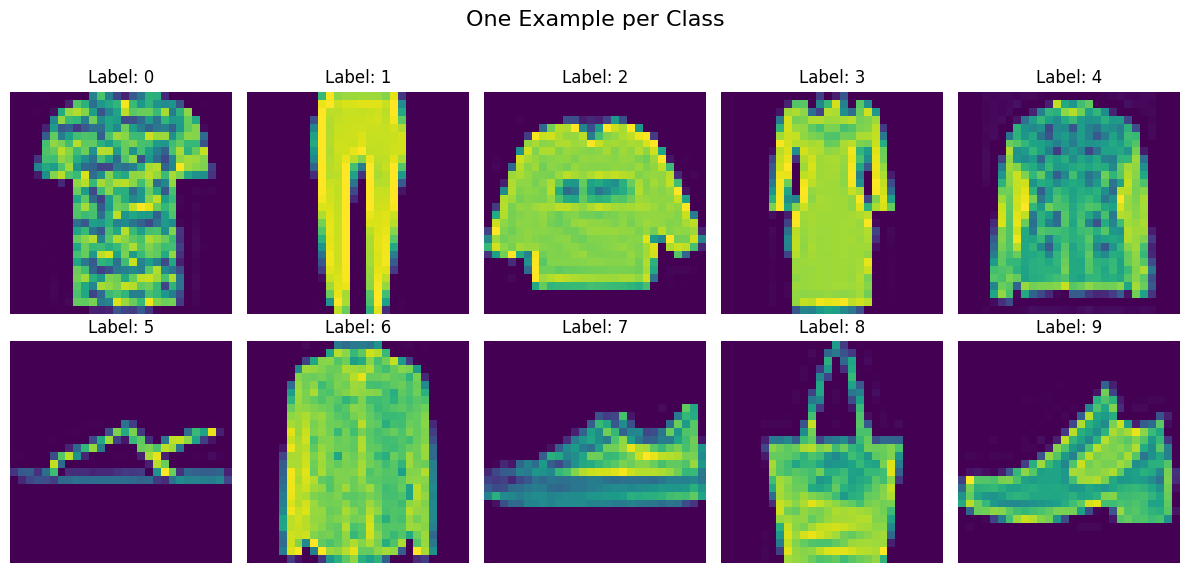

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("One Example per Class", fontsize=16)

# Loop through each class (0–9)
for cls, ax in enumerate(axes.flat):
    # Pick the first sample of this class
    img_row = df[df.iloc[:, 0] == cls].iloc[0]
    img = img_row[1:].values.reshape(28, 28)

    # Show the image
    ax.imshow(img, cmap="viridis")   # or "plasma", "inferno", "gray"
    ax.axis("off")
    ax.set_title(f"Label: {cls}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [7]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# scaling the feautures
X_train = X_train/255.0
X_test = X_test/255.0

In [10]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]])

In [11]:
# create CustomDataset Class

class  CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32) # In PT, usually, features are expected to be of float32 type
        self.labels = torch.tensor(labels, dtype=torch.long) # In PT, usually, labels are expected to be of long type

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [12]:
# create train_dataset object
train_dataset = CustomDataset(X_train, y_train)

In [13]:
len(train_dataset)

48000

In [14]:
# create test_dataset object
test_dataset = CustomDataset(X_test, y_test)

In [15]:
len(test_dataset)

12000

In [16]:
# create train and test loaders

# When pin_memory=True is passed to a DataLoader, the data tensors fetched by the
# loader are automatically placed into "pinned" memory in the CPU's RAM. This type
# of memory cannot be swapped out to disk by the operating system, which allows
# for faster and more direct asynchronous data transfers to the GPU's memory.

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

## ANN Design
Redesigned the ANN to be `dynamic and flexible`, allowing its architecture and parameters to be easily adjusted. This makes it well-suited for `hyperparameter tuning` with [OPTUNA](https://github.com/optuna/optuna).

In [17]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
        super().__init__()

        layers = []
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim, neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = neurons_per_layer

        layers.append(nn.Linear(neurons_per_layer, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, X):
        """
        In PyTorch, when a torch.nn.Module instance is created, it becomes callable
        directly like a function. This is because the `__call__` method is implemented
        within the `torch.nn.Module` class, which handles the necessary setup and then
        internally invokes the forward method that you define.
        """
        return self.model(X)

In [18]:
# Objective function for Optuna
def objective(trial):
    ## Suggest hyperparameters
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
    neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
    epochs = trial.suggest_int("epochs", 10, 50, step=10)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

    ## Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    ## Model initialization
    input_dim = 784  # 28x28 images flattened
    output_dim = 10  # Fashion-MNIST has 10 classes
    model = ANN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate).to(device)

    ## Loss function
    criterion = nn.CrossEntropyLoss()

    ## Optimizer selection
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    ## Training loop
    model.train()
    for epoch in range(epochs):
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # Forward pass
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)

            # Backward pass + update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    ## Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)

            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    return accuracy


# 🔹 Common Pruners
### 1. MedianPruner
- Stops trials that are worse than the **median** of completed trials at a given step.
- Simple and effective for many cases.

### 2. SuccessiveHalvingPruner
- Divides trials into "rungs".
- After each rung, keeps only the best-performing trials and **discards the rest**.
- More aggressive than MedianPruner.

### 3. HyperbandPruner
- Extension of **Successive Halving**.
- Dynamically allocates **more resources to better trials**.
- Efficient for large search spaces and expensive training.

### 4. ThresholdPruner
- Stops a trial if its performance is **below (or above)** a user-defined threshold.
- Useful when you have a clear baseline to beat.

---

# 🔹 Common Samplers

### 1. RandomSampler
- Samples parameters **randomly** from the search space.
- Good for quick baselines, but not efficient for large spaces.

### 2. TPESampler (Tree-structured Parzen Estimator)
- **Default sampler** in Optuna.
- Models promising regions of the search space and explores them more.
- Works well in most cases.

### 3. CmaEsSampler
- Uses **Covariance Matrix Adaptation Evolution Strategy (CMA-ES)**.
- Good for **continuous parameters**.
- Not as efficient for categorical/discrete parameters.

### 4. GridSampler
- Performs an **exhaustive search** over a user-defined grid of parameters.
- Useful for **small, discrete search spaces**.
- Not scalable for large spaces.

---


In [19]:
study = optuna.create_study(
    study_name="HyperParameter_tuning_ANN",  # custom study name
    direction="maximize",                    # since we optimize accuracy
    sampler=TPESampler(seed=42),             # reproducible TPE sampler
    pruner=MedianPruner(n_warmup_steps=3)    # prune/stop unpromising trials
)

[I 2025-09-17 15:10:06,233] A new study created in memory with name: HyperParameter_tuning_ANN


In [20]:
num_trials = 10    ### Increase/Decrease based on your Compute resources (~50-100 for optimal results if Search Space is huge)
study.optimize(objective, n_trials=num_trials)

[I 2025-09-17 15:11:22,085] Trial 0 finished with value: 0.8594166666666667 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 128, 'epochs': 40, 'learning_rate': 0.0024810409748678114, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 0.000462258900102083}. Best is trial 0 with value: 0.8594166666666667.
[I 2025-09-17 15:11:40,559] Trial 1 finished with value: 0.8434166666666667 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 24, 'epochs': 10, 'learning_rate': 0.00016480446427978953, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 0.00037183641805732076}. Best is trial 0 with value: 0.8594166666666667.
[I 2025-09-17 15:12:09,163] Trial 2 finished with value: 0.848 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 72, 'epochs': 30, 'learning_rate': 1.5339162591163613e-05, 'dropout_rate': 0.4, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 0.000233596350262616}. Best

In [21]:
study.best_value

0.88775

In [22]:
study.best_params

{'num_hidden_layers': 5,
 'neurons_per_layer': 120,
 'epochs': 30,
 'learning_rate': 0.04869640941520897,
 'dropout_rate': 0.1,
 'batch_size': 128,
 'optimizer': 'SGD',
 'weight_decay': 3.6464395589807184e-05}

## Optuna Visualization Charts

In [23]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_contour, plot_param_importances

In [24]:
# 1. Optimization History
plot_optimization_history(study).show()

In [25]:
# 2. Parallel Coordinates Plot
plot_parallel_coordinate(study).show()

In [26]:
# 3. Slice Plot
plot_slice(study).show()

In [30]:
# 4. Contour Plot
plot_contour(study).show()

In [28]:
# 5. Hyperparameter Importance
plot_param_importances(study).show()